In [16]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('classic')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
data= pd.read_csv('/data/Good data storage.csv')
data.head()

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
0,2016072704,27,3,0,0,0,1,"26,27,28,29","34,35",1,0,NaN,50Hz IE preonly
1,2017021501,30,3,0,0,0,2,"12,13","16,17",1,0,NaN,50Hz IE preonly
2,2016091403,30,2,0,0,0,1,"14,15",18,1,1,NaN,50Hz IE preonly
3,2017062202,24,1,0,0,0,1,"30,31,32",35,1,0,"No change, good data",50Hz IE preonly
4,2016072902,29,1,0,1,0,0,43,"45,46,47,48,49",1,0,NaN,50Hz IE preonly


In [18]:
data_pre_50Hz_reci = data[(data['Ptl_note']=='50Hz EI preonly')&(data['Reci']==1)]
data_pre_50Hz_uni = data[(data['Ptl_note']=='50Hz EI preonly')&(data['Reci']==0)]

In [19]:
data_pre_50Hz_reci

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
12,2016092903,29,2,1,1,0,1,"4,5","7,8",2,0,NaN,50Hz EI preonly
14,2016091201,28,2,1,1,0,1,"16,17,18","21,22,23,24,25",2,13,NaN,50Hz EI preonly
15,2016100201,26,1,1,1,0,2,"3,4","6,7,8",2,0,NaN,50Hz EI preonly
16,2016100303,27,1,1,1,0,2,"4,5","8,9,10,11,12",2,7,Increased PPR,50Hz EI preonly
17,2016100304,27,2,1,1,0,2,11,"13,14,15,16",2,4,"Reduced onset tau, incrased decay tau",50Hz EI preonly
18,2017021302,30,1,1,1,0,2,5,"7,8,9,10",2,0,Increased onset tau,50Hz EI preonly


In [5]:
data_pre_50Hz_uni

,File name,Age,Pip number,E-I,Reci,Artifact,IS100,Trial number before,Trial number after,Protocol,Elimi,Notes,Ptl_note
9,2016081002,27,1,1,0,0,0,1,"4,5,6",2,0,NaN,50Hz EI preonly
10,2016081703,26,2,1,0,0,1,"14,15,16,17","20,21,22,23",2,0,NaN,50Hz EI preonly
11,2016081002,28,1,1,0,0,0,1,"4,5,6,7,8",2,0,Reduced PPR,50Hz EI preonly
13,2016101201,30,2,1,0,0,2,"9,10","12,13,14,15",2,4,Reduced PPR,50Hz EI preonly
19,2017053101,34,2,1,0,1,1,"5,6","8,9",2,18,NaN,50Hz EI preonly
20,2017051501,32,1,1,0,0,1,7,"9,10",2,0,NaN,50Hz EI preonly


<Container object of 3 artists>

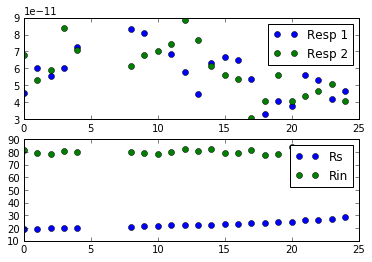

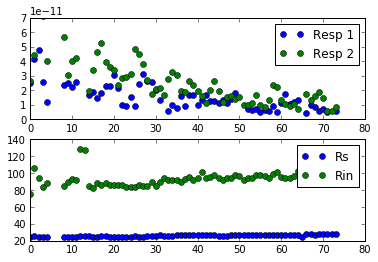

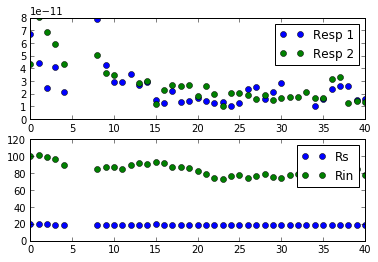

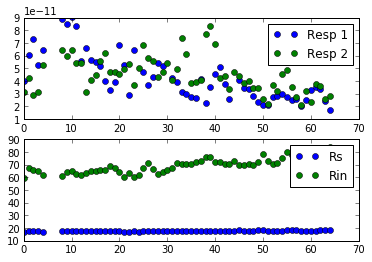

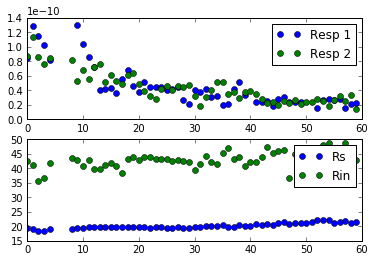

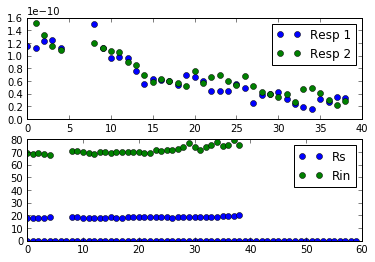

In [20]:
# patch_pip.df_ana(data_pre_50Hz_reci,'/data/data_pre_50Hz_reci', end_ana=[40,60,25,40,30,35])
patch_pip.df_ana(data_pre_50Hz_reci,'/data/data_pre_50Hz_reci')
pre_50Hz_reci = pd.read_pickle('/data/data_pre_50Hz_reci')
ave_ptl_mean, ave_ptl_ste = patch_pip.sample_plot(pre_50Hz_reci)
plt.errorbar(x=np.arange(len(ave_ptl_mean)), y=ave_ptl_mean, yerr=ave_ptl_ste, fmt='bo')

In [22]:
elimi = np.array([20,40,35,50,40,35])
elimi_sr = pd.Series(elimi, index=pre_50Hz_reci.index)
pre_50Hz_reci['elimi']=elimi_sr

In [24]:
spon_elimi_bef = {}
spon_elimi_bef[12] = [6,8,26,27,30]   # 66 126
spon_elimi_bef[14] = [17,25,26,27]  # 36 96
spon_elimi_bef[15] = [6] # 66 126
spon_elimi_bef[16] = [1,5,6,11,12,21,22,37,]  # 66 126
spon_elimi_bef[17] = [1,2,21,24,25,26] # 36 96
spon_elimi_bef[18] = [0] # 66 126
spon_elimi_aft = {}
spon_elimi_aft[12] = [0]   # 66 126
spon_elimi_aft[14] = [47]  # 36 96
spon_elimi_aft[15] = [72]  # 66 126
spon_elimi_aft[16] = [77,84,89,94,95,96,102,106,108,109,110,115,122,123,125,126]  # 66 126
spon_elimi_aft[17] = [38,42,45,47,49,54,56,59,65,66,67,69,79,80,91,92,93,94,95] # 36 96
spon_elimi_aft[18] = [75] # 66 126

In [25]:
pre_50Hz_reci['spon_elimi_bef'] = pd.Series(spon_elimi_bef, index=pre_50Hz_reci.index)
pre_50Hz_reci['spon_elimi_aft'] = pd.Series(spon_elimi_aft, index=pre_50Hz_reci.index)
pre_50Hz_reci.to_pickle('/data/ana_pre_50Hz_reci')

In [10]:
spon_elimi_bef = {}
spon_elimi_aft = {}
spon_elimi_bef[12] = [30]   # 21 51
spon_elimi_bef[14] = [22, 24, 25, 26, 27, 28, 29, ]  # 36 66
spon_elimi_bef[15] = [17, 24, 31]  # 6-36
spon_elimi_bef[16] = [1, 22] # 36 96
spon_elimi_bef[17] = [1,2 , 7, 10, 21, 22, 24, 25, 28, 29, 30, 32] # 36 96
spon_elimi_bef[18] = []

/src/Patch_ana/Patch_ana/patch_pip.py:572: RuntimeWarning: overflow encountered in exp
  y = np.exp(-1 * t / decay_tau)


<Container object of 3 artists>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

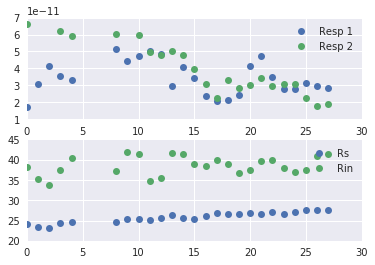

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

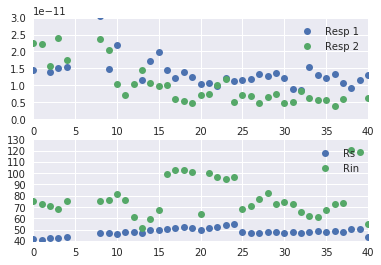

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

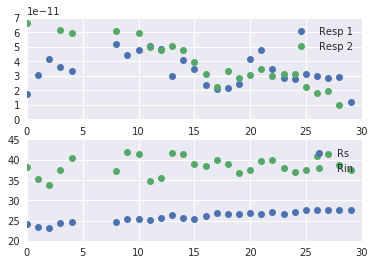

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

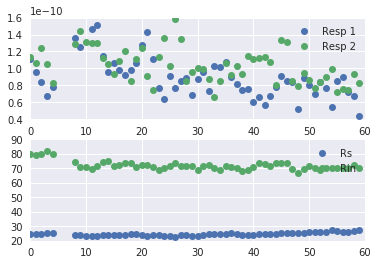

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

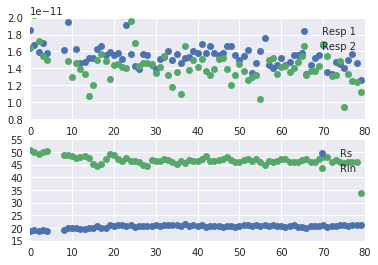

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

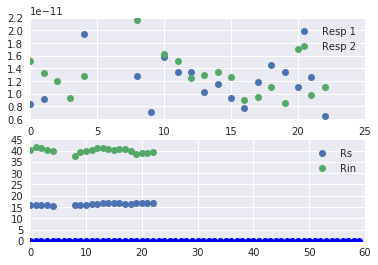

In [11]:
patch_pip.df_ana(data_pre_50Hz_uni,'/data/data_pre_50Hz_uni')
pre_50Hz_uni = pd.read_pickle('/data/data_pre_50Hz_uni')
ave_ptl_mean, ave_ptl_ste = patch_pip.sample_plot(pre_50Hz_uni)
plt.errorbar(x=np.arange(len(ave_ptl_mean)), y=ave_ptl_mean, yerr=ave_ptl_ste, fmt='bo')

In [12]:
pre_50Hz_uni.index

Int64Index([9, 10, 11, 13, 19, 20], dtype='int64')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

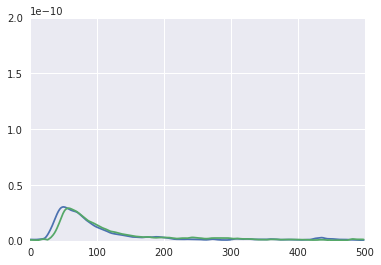

In [13]:
sample_id = 9
plt.plot(np.nanmean(np.vstack(pre_50Hz_uni['Before'].loc[sample_id]['trace_y1'])[:, :500], axis=0))
plt.plot(np.nanmean(np.vstack(pre_50Hz_uni['After'].loc[sample_id]['trace_y1'])[-5:,:500], axis=0))
plt.ylim([0, 2e-10])
with PdfPages('/data/Figure5_3.pdf') as pdf:
    pdf.savefig()

In [14]:
elimi = np.array([27,40,28,17,50,22])
elimi_sr = pd.Series(elimi, index=pre_50Hz_uni.index)
pre_50Hz_uni['elimi']=elimi_sr
pre_50Hz_uni.to_pickle('/data/ana_pre_50Hz_uni')